In [2]:
from pandas.errors import EmptyDataError
import pandas as pd
import os 
import glob 

csv_files = glob.glob(os.path.join("results/", "*.csv")) 
  
dfs = []
for f in csv_files:       
    try:
        df = pd.read_csv(f)
        if len(df) > 0:
            df['layer'] = df['NameAnalyser.name'].index + 1 
            df['last'] = 'last' in f 
            dfs.append(df)
    except EmptyDataError:
        continue
        
df = pd.concat(dfs, ignore_index=True)

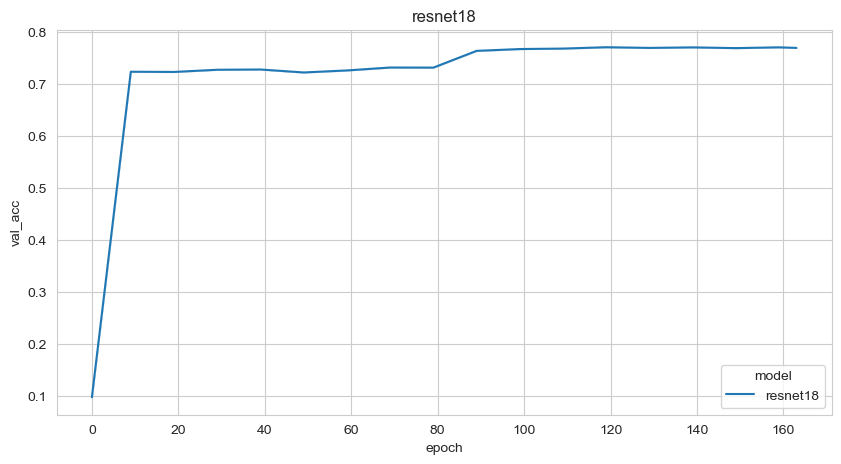

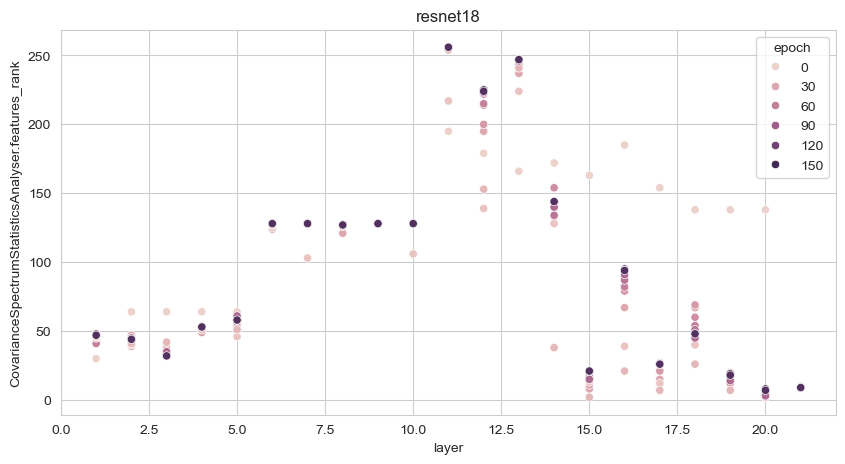

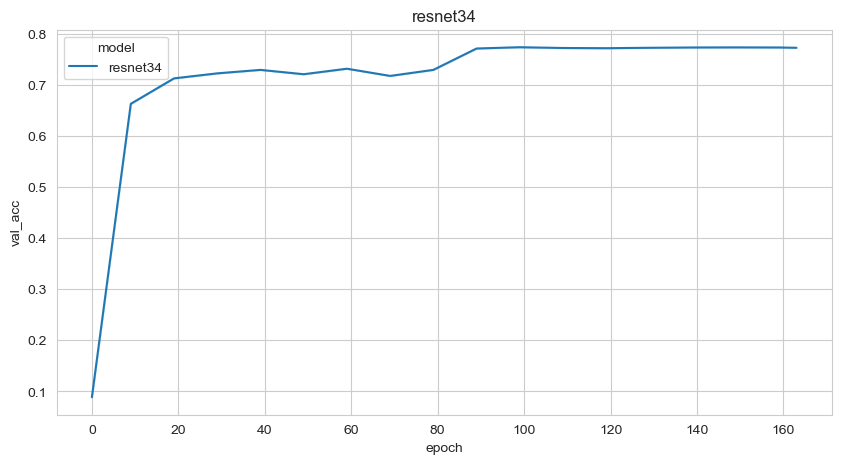

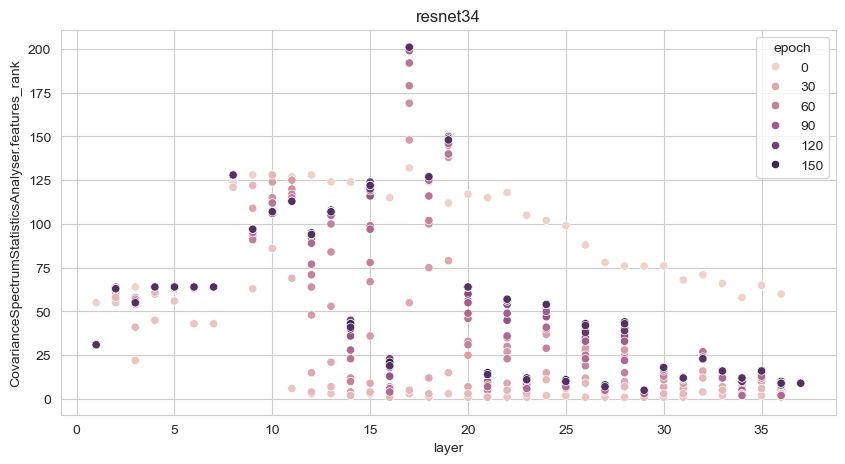

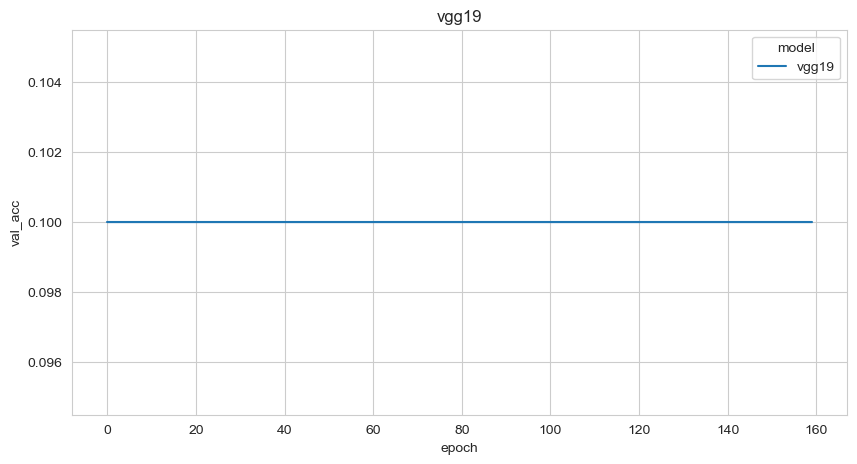

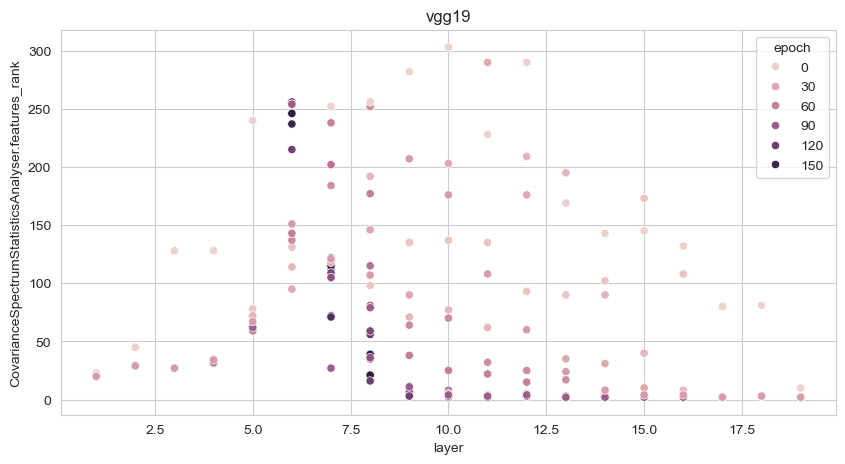

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

for model in ['resnet18', 'resnet34', 'vgg19']:
    df2 = df[(df['model']==model) & (df['dataset']=='cifar10') & (df['seed']==0)]
    plt.figure(figsize = (10,5))
    plt.title(model)
    sns.lineplot(x="epoch", y="val_acc", hue="model", data=df2)
    
    plt.figure(figsize = (10,5))
    plt.title(model)
    sns.scatterplot(x="layer", y="CovarianceSpectrumStatisticsAnalyser.features_rank", hue='epoch', data=df2)


In [3]:
df2[df2['name']=='features.0']

,Unnamed: 0,name,output,model,dataset,lr,seed,epoch,val_acc,features_rank,features_dim,normalized_features_rank,weights_rank,layer,last


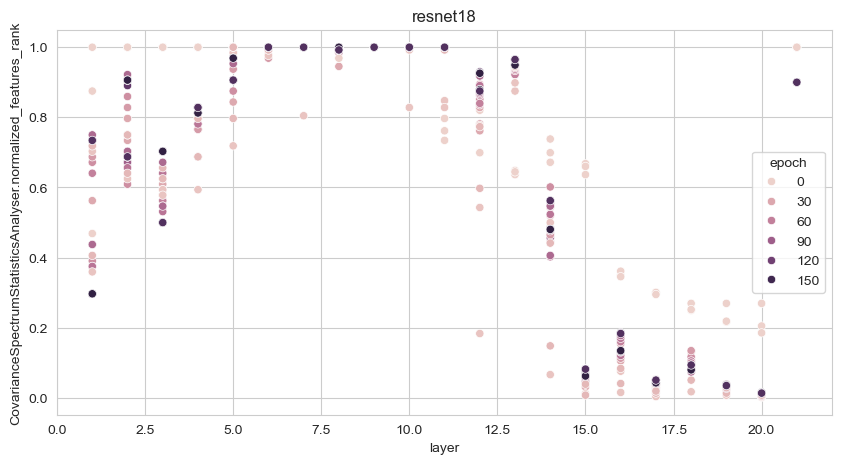

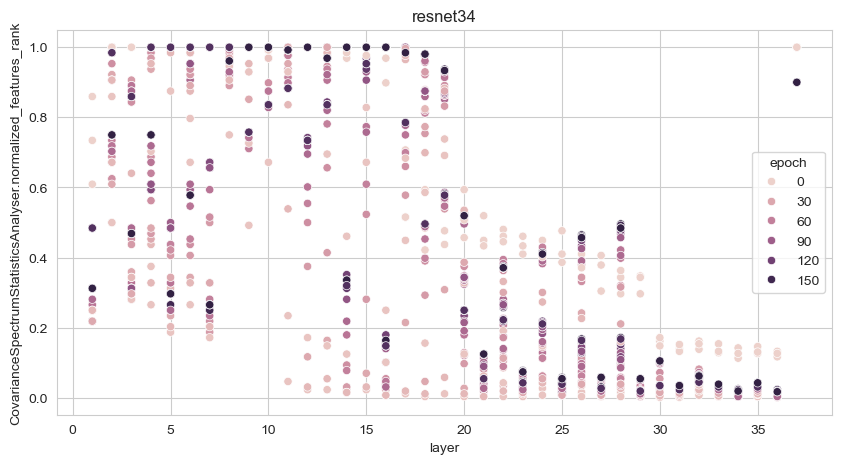

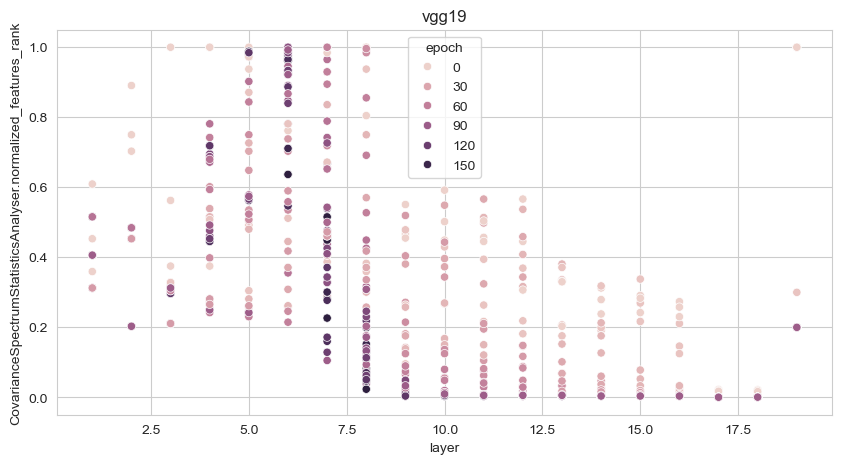

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

for model in ['resnet18', 'resnet34', 'vgg19']:
    df2 = df[(df['model']==model) & (df['dataset']=='cifar10')]
    
    plt.figure(figsize = (10,5))
    plt.title(model)
    sns.scatterplot(x="layer", y="CovarianceSpectrumStatisticsAnalyser.normalized_features_rank", hue='epoch', data=df2)


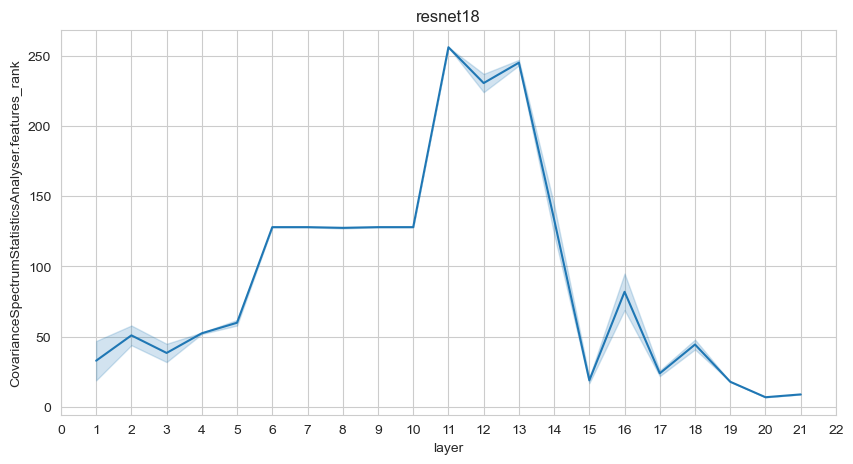

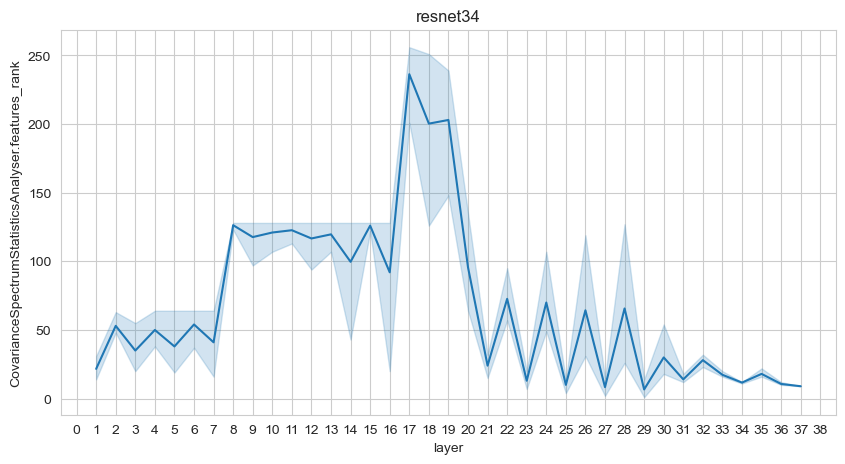

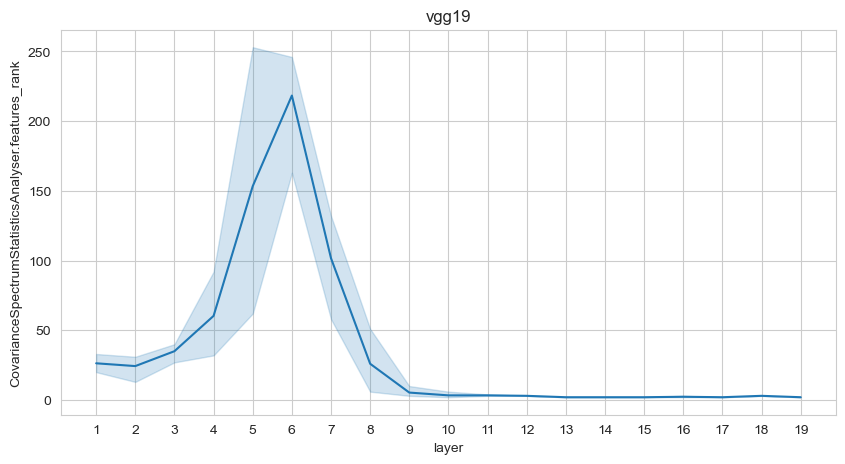

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

for model in ['resnet18', 'resnet34', 'vgg19']:
    df2 = df[(df['model']==model) & (df['dataset']=='cifar10') & df['last']]
    
    plt.figure(figsize = (10,5))
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    plt.gca().xaxis.set_major_locator(loc)
    plt.title(model)
    sns.lineplot(x="layer", y="CovarianceSpectrumStatisticsAnalyser.features_rank", data=df2)


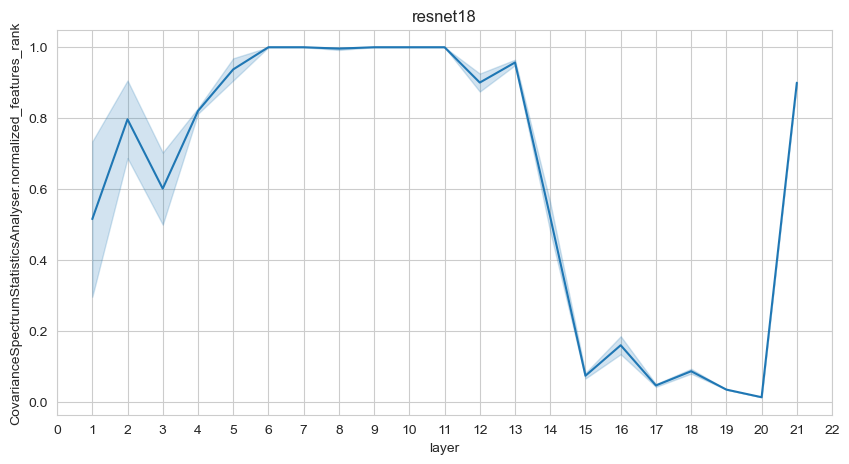

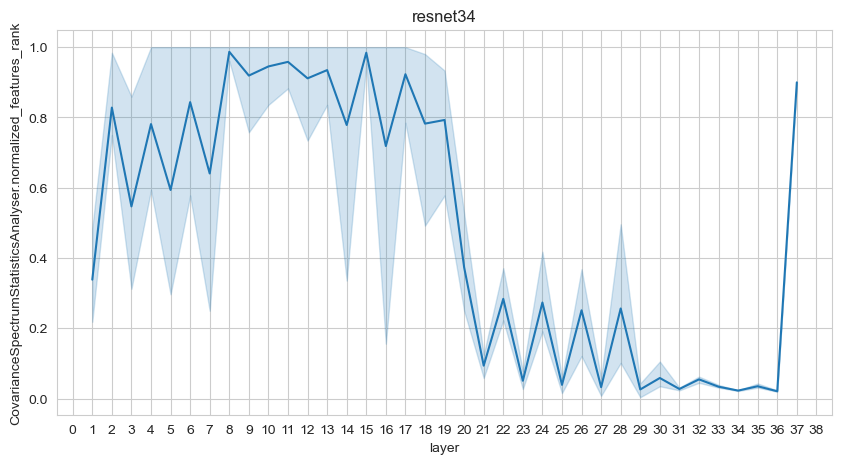

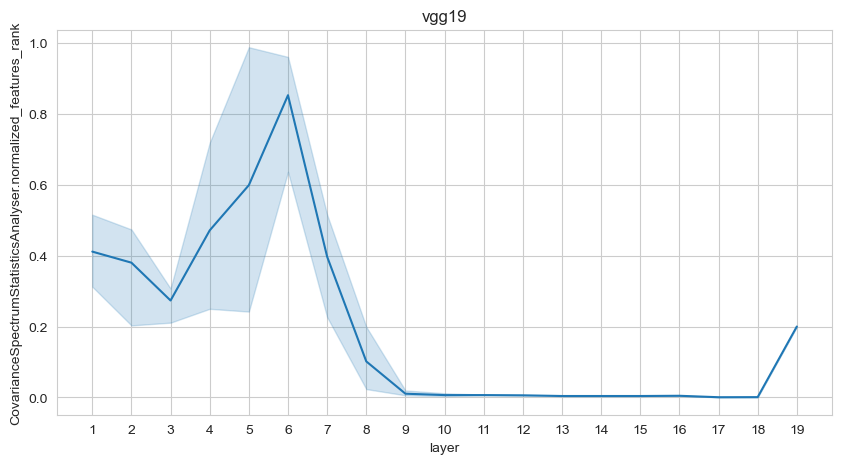

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

for model in ['resnet18', 'resnet34', 'vgg19']:
    df2 = df[(df['model']==model) & (df['dataset']=='cifar10') & df['last']]
    
    plt.figure(figsize = (10,5))
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    plt.gca().xaxis.set_major_locator(loc)
    plt.title(model)
    sns.lineplot(x="layer", y="CovarianceSpectrumStatisticsAnalyser.normalized_features_rank", data=df2)
    
    df2 = df[(df['model']==model) & (df['lr']<0.1) & (df['dataset']=='cifar10') & (df['epoch']==0)]
    sns.lineplot(x="layer", y="CovarianceSpectrumStatisticsAnalyser.normalized_features_rank", data=df2)

In [14]:
df[(df['model']=='vgg19') & (df['dataset']=='cifar10') & (df['epoch']==0) & (df['NameAnalyser.name']=='features.0')]

,Unnamed: 0,NameAnalyser.name,CovarianceSpectrumStatisticsAnalyser.mean,CovarianceSpectrumStatisticsAnalyser.max,CovarianceSpectrumStatisticsAnalyser.features_rank,CovarianceSpectrumStatisticsAnalyser.features_rank_val,CovarianceSpectrumStatisticsAnalyser.half_rank_val,CovarianceSpectrumStatisticsAnalyser.quarter_rank_val,CovarianceSpectrumStatisticsAnalyser.normalised_spectrum_0,CovarianceSpectrumStatisticsAnalyser.normalised_spectrum_1,...,LinearProbe.train_acc,output,model,dataset,lr,seed,epoch,val_acc,layer,last
1698,0,features.0,0.086907,4.448416,29,0.004582,0.011217,0.032141,4.448416,0.042274,...,0.38576,/scratch/jsh2/tunnel/models,vgg19,cifar10,0.1,2,0,0.0994,1,False
2193,0,features.0,0.152380,7.936756,23,0.008128,0.025307,0.108921,7.936756,0.073595,...,0.38766,/scratch/jsh2/tunnel/models,vgg19,cifar10,0.1,0,0,0.1000,1,False
2781,0,features.0,0.034136,1.162340,39,0.001177,0.013212,0.030962,1.162340,0.038081,...,0.38328,/scratch/jsh2/tunnel/models,vgg19,cifar10,0.1,1,0,0.1029,1,False


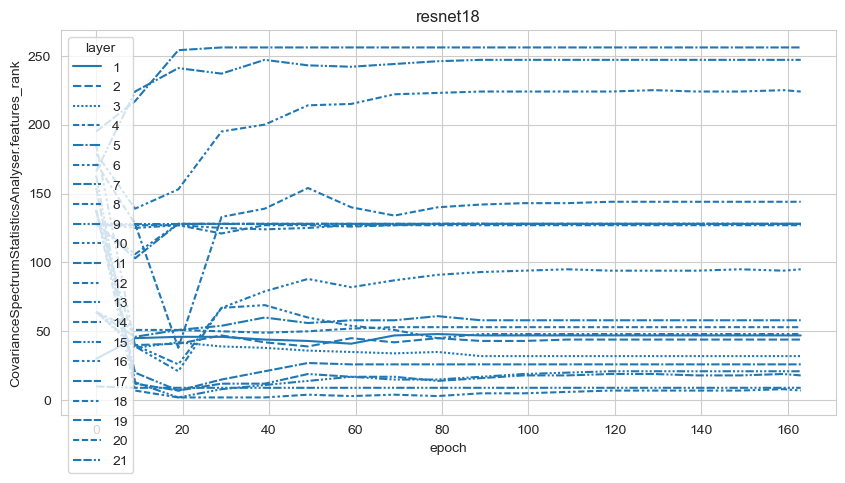

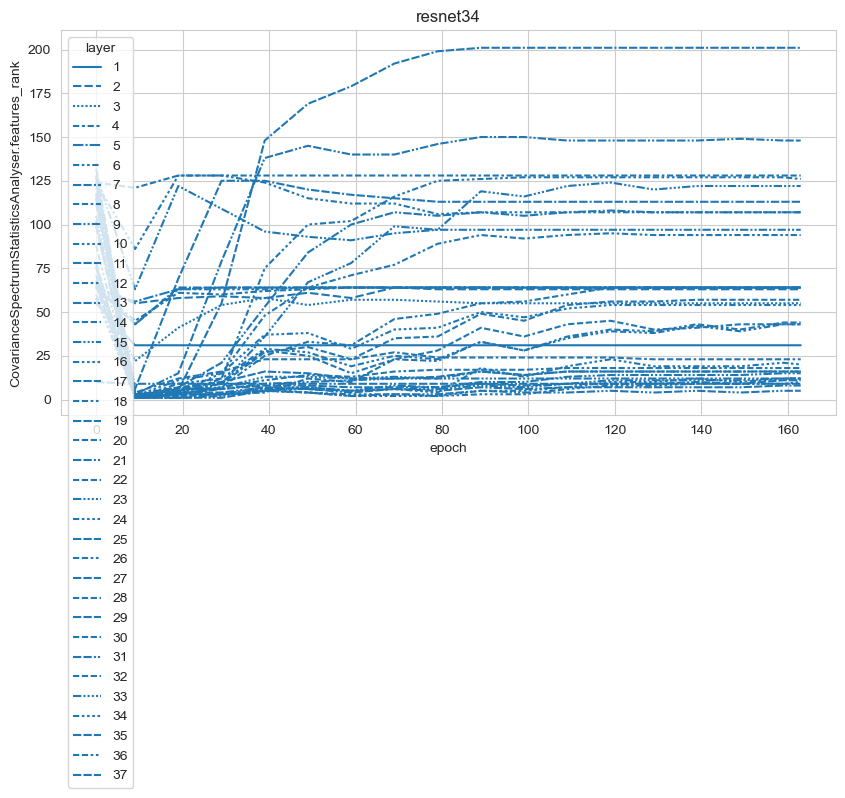

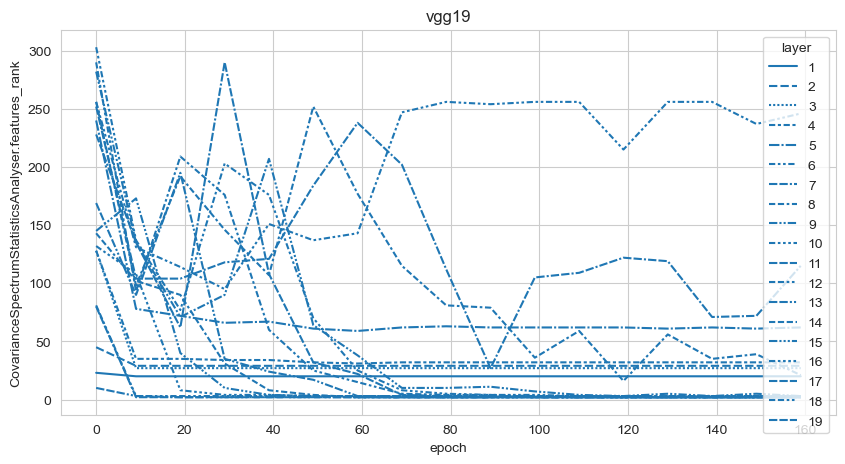

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

for model in ['resnet18', 'resnet34', 'vgg19']:
    df2 = df[(df['model']==model) & (df['dataset']=='cifar10') & (df['seed']==0)]
    
    plt.figure(figsize = (10,5))
    plt.title(model)
    sns.lineplot(x="epoch", y="CovarianceSpectrumStatisticsAnalyser.features_rank", data=df2, style='layer')

In [17]:
df

,Unnamed: 0,NameAnalyser.name,CovarianceSpectrumStatisticsAnalyser.mean,CovarianceSpectrumStatisticsAnalyser.max,CovarianceSpectrumStatisticsAnalyser.features_rank,CovarianceSpectrumStatisticsAnalyser.features_rank_val,CovarianceSpectrumStatisticsAnalyser.half_rank_val,CovarianceSpectrumStatisticsAnalyser.quarter_rank_val,CovarianceSpectrumStatisticsAnalyser.normalised_spectrum_0,CovarianceSpectrumStatisticsAnalyser.normalised_spectrum_1,...,LinearProbe.train_acc,output,model,dataset,lr,seed,epoch,val_acc,layer,last
0,0,conv1,2.336238e+01,6.467162e+02,47,7.330356e-01,6.155377e+00,2.078632e+01,6.467162e+02,5.075267e+01,...,0.31164,/scratch/jsh2/tunnel/models,resnet18,cifar10,0.1,0,163,0.769,1,True
1,1,layer1.0.conv1,2.777922e+00,9.024644e+01,44,9.336913e-02,6.786504e-01,2.182962e+00,9.024644e+01,4.437702e+00,...,0.61950,/scratch/jsh2/tunnel/models,resnet18,cifar10,0.1,0,163,0.769,2,True
2,2,layer1.0.conv2,3.685073e-01,1.169745e+01,32,1.483966e-02,1.139539e-01,4.150375e-01,1.169745e+01,6.089988e-01,...,0.67786,/scratch/jsh2/tunnel/models,resnet18,cifar10,0.1,0,163,0.769,3,True
3,3,layer1.1.conv1,4.763671e+00,7.458026e+01,53,7.766246e-02,1.018138e+00,5.216025e+00,7.458026e+01,1.433197e+01,...,0.66022,/scratch/jsh2/tunnel/models,resnet18,cifar10,0.1,0,163,0.769,4,True
4,4,layer1.1.conv2,2.441592e-01,3.610150e+00,58,4.899865e-03,7.423844e-02,2.186300e-01,3.610150e+00,5.314283e-01,...,0.73340,/scratch/jsh2/tunnel/models,resnet18,cifar10,0.1,0,163,0.769,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,14,features.32,8.363081e-22,4.210611e-19,2,7.041145e-21,4.210611e-19,4.210611e-19,4.210611e-19,3.094605e-29,...,0.09880,/scratch/jsh2/tunnel/models,vgg19,cifar10,0.1,1,89,0.100,15,False
3797,15,features.34,1.895608e-21,9.515545e-19,2,1.896288e-20,9.515545e-19,9.515545e-19,9.515545e-19,8.743921e-29,...,0.09738,/scratch/jsh2/tunnel/models,vgg19,cifar10,0.1,1,89,0.100,16,False
3798,16,classifier.0,8.156285e-23,3.258562e-19,2,8.221822e-21,3.258562e-19,3.258562e-19,3.258562e-19,5.852894e-30,...,0.09750,/scratch/jsh2/tunnel/models,vgg19,cifar10,0.1,1,89,0.100,17,False
3799,17,classifier.3,1.906065e-22,7.511560e-19,3,1.081190e-20,1.875480e-20,7.511560e-19,7.511560e-19,7.671513e-29,...,0.09826,/scratch/jsh2/tunnel/models,vgg19,cifar10,0.1,1,89,0.100,18,False


In [18]:
df['model'].unique()

array(['resnet18', 'vgg19', 'resnet34'], dtype=object)

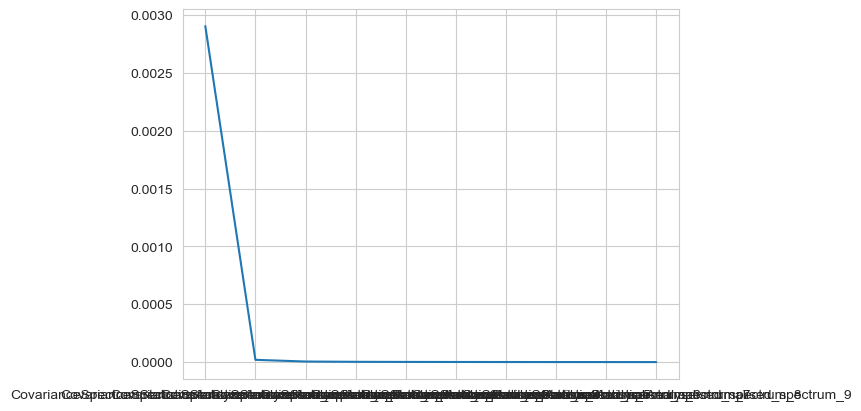

In [53]:
df2 = df[(df['model']=='vgg19') & (df['dataset']=='cifar10') & (df['seed']==0) & (df['NameAnalyser.name']=='features.10') & (df['epoch'] == 19)].T
df2 = df2[['CovarianceSpectrumStatisticsAnalyser.normalised_spectrum_' in s for s in df2.index]]
plt.plot(df2)

In [54]:
df

,Unnamed: 0,NameAnalyser.name,CovarianceSpectrumStatisticsAnalyser.mean,CovarianceSpectrumStatisticsAnalyser.max,CovarianceSpectrumStatisticsAnalyser.features_rank,CovarianceSpectrumStatisticsAnalyser.features_rank_val,CovarianceSpectrumStatisticsAnalyser.half_rank_val,CovarianceSpectrumStatisticsAnalyser.quarter_rank_val,CovarianceSpectrumStatisticsAnalyser.normalised_spectrum_0,CovarianceSpectrumStatisticsAnalyser.normalised_spectrum_1,...,LinearProbe.train_acc,output,model,dataset,lr,seed,epoch,val_acc,layer,last
0,0,conv1,2.336238e+01,6.467162e+02,47,7.330356e-01,6.155377e+00,2.078632e+01,6.467162e+02,5.075267e+01,...,0.31164,/scratch/jsh2/tunnel/models,resnet18,cifar10,0.1,0,163,0.769,1,True
1,1,layer1.0.conv1,2.777922e+00,9.024644e+01,44,9.336913e-02,6.786504e-01,2.182962e+00,9.024644e+01,4.437702e+00,...,0.61950,/scratch/jsh2/tunnel/models,resnet18,cifar10,0.1,0,163,0.769,2,True
2,2,layer1.0.conv2,3.685073e-01,1.169745e+01,32,1.483966e-02,1.139539e-01,4.150375e-01,1.169745e+01,6.089988e-01,...,0.67786,/scratch/jsh2/tunnel/models,resnet18,cifar10,0.1,0,163,0.769,3,True
3,3,layer1.1.conv1,4.763671e+00,7.458026e+01,53,7.766246e-02,1.018138e+00,5.216025e+00,7.458026e+01,1.433197e+01,...,0.66022,/scratch/jsh2/tunnel/models,resnet18,cifar10,0.1,0,163,0.769,4,True
4,4,layer1.1.conv2,2.441592e-01,3.610150e+00,58,4.899865e-03,7.423844e-02,2.186300e-01,3.610150e+00,5.314283e-01,...,0.73340,/scratch/jsh2/tunnel/models,resnet18,cifar10,0.1,0,163,0.769,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,14,features.32,8.363081e-22,4.210611e-19,2,7.041145e-21,4.210611e-19,4.210611e-19,4.210611e-19,3.094605e-29,...,0.09880,/scratch/jsh2/tunnel/models,vgg19,cifar10,0.1,1,89,0.100,15,False
3797,15,features.34,1.895608e-21,9.515545e-19,2,1.896288e-20,9.515545e-19,9.515545e-19,9.515545e-19,8.743921e-29,...,0.09738,/scratch/jsh2/tunnel/models,vgg19,cifar10,0.1,1,89,0.100,16,False
3798,16,classifier.0,8.156285e-23,3.258562e-19,2,8.221822e-21,3.258562e-19,3.258562e-19,3.258562e-19,5.852894e-30,...,0.09750,/scratch/jsh2/tunnel/models,vgg19,cifar10,0.1,1,89,0.100,17,False
3799,17,classifier.3,1.906065e-22,7.511560e-19,3,1.081190e-20,1.875480e-20,7.511560e-19,7.511560e-19,7.671513e-29,...,0.09826,/scratch/jsh2/tunnel/models,vgg19,cifar10,0.1,1,89,0.100,18,False


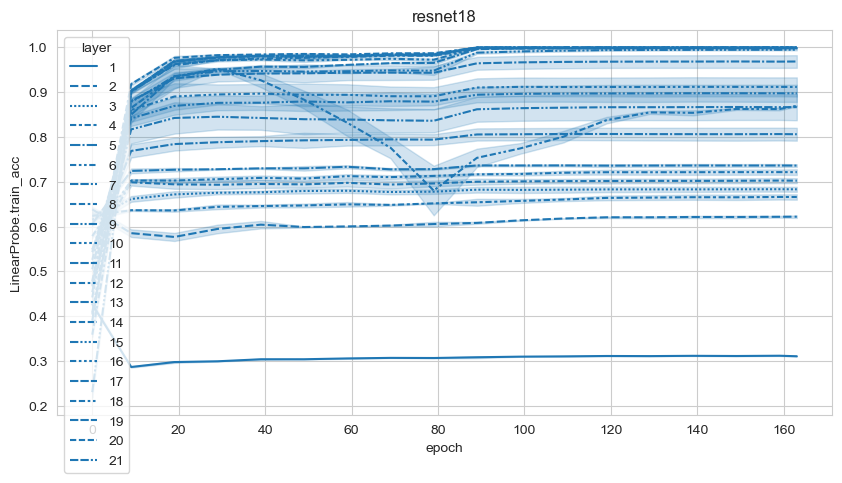

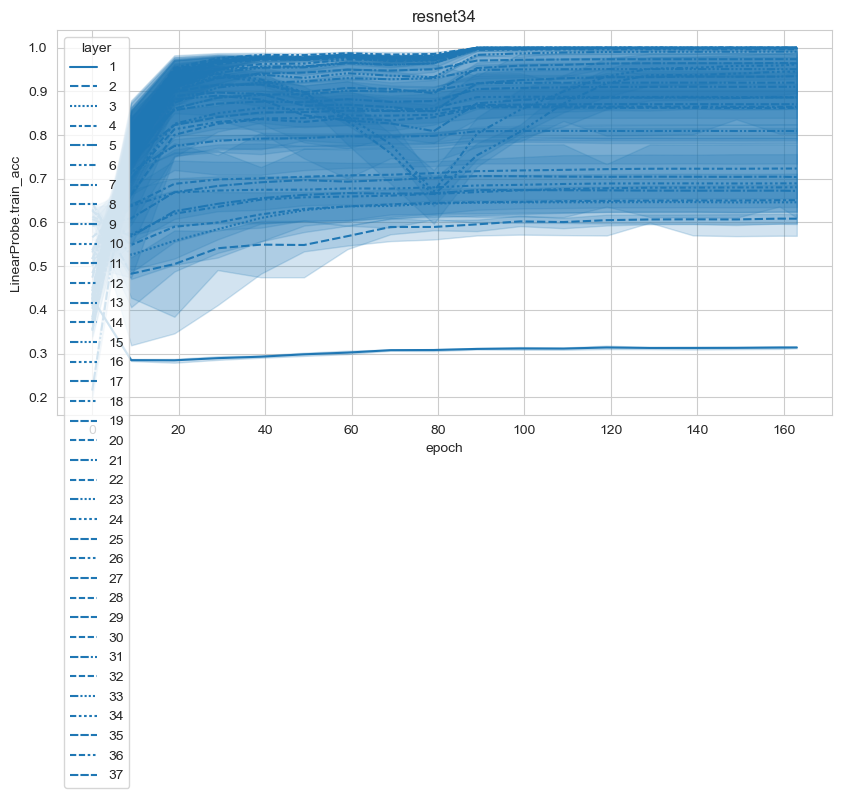

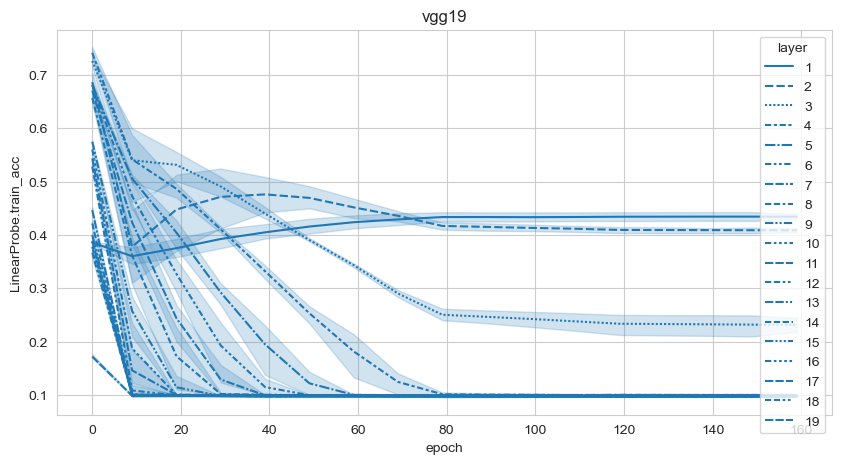

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

for model in ['resnet18', 'resnet34', 'vgg19']:
    df2 = df[(df['model']==model) & (df['dataset']=='cifar10')]
    
    plt.figure(figsize = (10,5))
    plt.title(model)
    sns.lineplot(x="epoch", y="LinearProbe.train_acc", data=df2, style='layer')

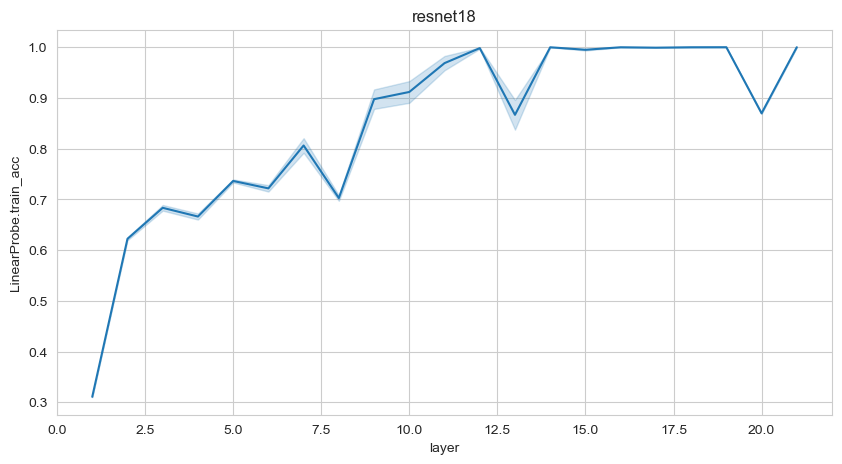

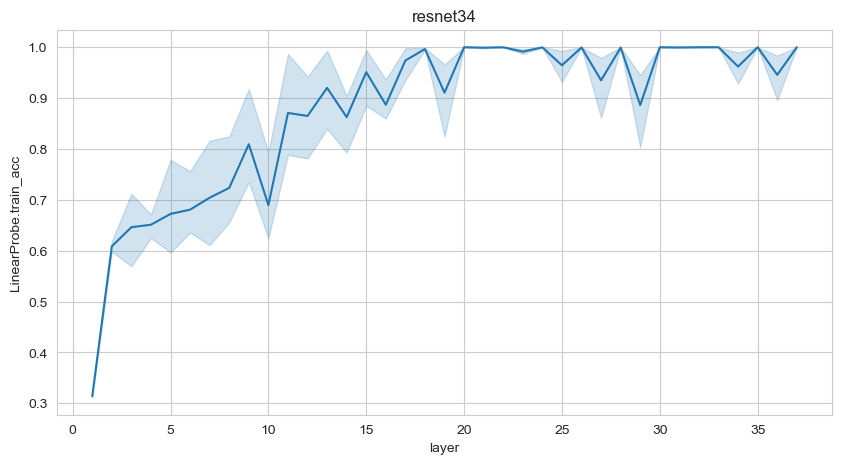

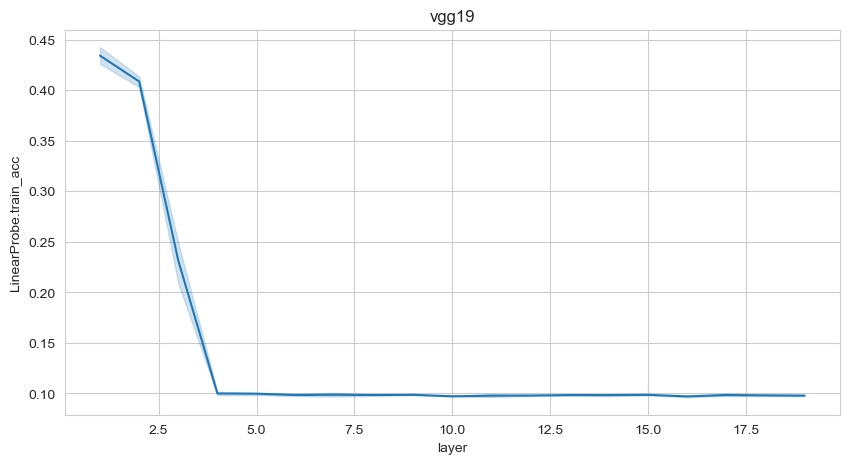

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

for model in ['resnet18', 'resnet34', 'vgg19']:
    df2 = df[(df['model']==model) & (df['dataset']=='cifar10') & df['last']]
    
    plt.figure(figsize = (10,5))
    plt.title(model)
    sns.lineplot(x="layer", y="LinearProbe.train_acc", data=df2)